# Undersampling & individual Gridsearch

This notebook discusses Multi-label classification methods using undersampling for the [academia.stackexchange.com](https://academia.stackexchange.com/).

A classifier is trained for each label individually. The best parameter is obtained for each classifier using *Gridsearch*. The training data for each classifier is adjusted using *undersampling*. This approach is a combination of the approaches shown in [notebook 4.5.1](4.5.1-me-classwise-gridsearch.ipynb) and [notebook 4.5.2](4.5.2-me-classwise-undersampling.ipynb).

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import re
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import load
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths

RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.experiments.data import ExperimentalData

ed = ExperimentalData.load()
X_train, X_test, y_train, y_test = ed.get_train_test_set()

In [3]:
from academia_tag_recommender.experiments.transformer import BagOfWordsTransformer, Word2VecTransformer, FastTextTransformer, Doc2VecTransformer
from academia_tag_recommender.experiments.experimental_classifier import ExperimentalClassifier

<a id='data_preparation'/>

## Data Preparation

In [4]:
def create_classifier(classifier_options, name, embedding=''):
    classifier = ClasswiseClassifier(name, classifier_options, embedding, undersample=True)
    experimental_classifier = ExperimentalClassifier.load(transformer, classifier, name)
    experimental_classifier.train(train, y_train)
    experimental_classifier.score(test, y_test)
    print('Training: {}s'.format(experimental_classifier.training_time))
    print('Test: {}s'.format(experimental_classifier.test_time))
    experimental_classifier.evaluation.print_stats()

<a id='training'/>

## Training

The [Classwise Classifier](../classwise_classifier.py) is trained for three different classification methods and their specific tuning parameter is found using [Gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) as in [notebook 4.5.1](4.5.1-me-classwise-gridsearch.ipynb).
- Linear SVC, optimizing parameter `C`
- Logistic Regression, optimizing parameter `C`
- MLPClassifier, optimizing parameter `alpha`

[Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall#sklearn.metrics.recall_score) is used as  the scoring-function for the optimization. For reasons of that decision see [notebook 3.0](3.0-me-evaluation-metrics.ipynb).

In addition undersampling is used for each individual label as in [notebook 4.5.2](4.5.2-me-classwise-undersampling.ipynb) Instead of handing all samples to the classifier, a more balanced ratio is used as training data. The [Classwise Classifier](../classwise_classifier.py) uses a ratio of 1:25, depending on how many positive samples are available in the original data.

In [5]:
from academia_tag_recommender.classwise_classifier import ClasswiseClassifier, ClassifierOption
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

**Word2Vec**

In [6]:
transformer = Word2VecTransformer.load('word2vec')
train = transformer.fit(X_train)
test = transformer.transform(X_test)

In [7]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'word2vec')

Classifier not available. Initiating data.
Training: 608.5489790439606s
Test: 3.182091236114502s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01576847196588812      0.0380894800483676       0.3509000437960535       0.29976420798065295      0.28830582758635964      
micro                                                            0.37752016129032256      0.28684953803437213      0.32599766056418483      
macro                                                            0.278823189359305        0.32780655481266074      0.24645282812463068      


In [8]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'word2vec')

Classifier not available. Initiating data.
Training: 285.3279507160187s
Test: 2.2602076530456543s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013944504550372303     0.051148730350665056     0.39339628797911746      0.3078355501813784       0.3107693703582458       
micro                                                            0.4618371919342793       0.2960409785054335       0.36080399078152803      
macro                                                            0.32415834051392034      0.28781698080980134      0.27217502276768224      


In [9]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
#create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'word2vec')

**Doc2Vec**

In [10]:
transformer = Doc2VecTransformer.load('doc2vec')
train = transformer.fit(X_train)
test = transformer.transform(X_test)

In [11]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'doc2vec')

Classifier not available. Initiating data.
Training: 3503.993540287018s
Test: 4.064192533493042s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.03092343919047922      0.014631197097944377     0.1296582543145745       0.22395808141878276      0.13691934304307946      
micro                                                            0.12700293539439314      0.2257647565704438       0.16255902933370103      
macro                                                            0.1724023025325194       0.3230222427238376       0.14398334838149618      


In [12]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'doc2vec')

Classifier not available. Initiating data.
Training: 214.07281231880188s
Test: 3.8780252933502197s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.031578947368421054     0.016324062877871828     0.15467145856474         0.2708847239016526       0.1622900452482539       
micro                                                            0.14311976747074753      0.2757910862176265       0.18844656700794873      
macro                                                            0.1589450833921673       0.36028750055231007      0.16106103422344276      


In [13]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
#create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'doc2vec')

**FastText**

In [14]:
transformer = FastTextTransformer.load('fasttext')
train = transformer.fit(X_train)
test = transformer.transform(X_test)

In [15]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'fasttext')

Classifier not available. Initiating data.
Training: 614.7422275543213s
Test: 2.167720317840576s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.015608095207789729     0.03796856106408706      0.36076088663452627      0.3163744457879887       0.3015805597063155       
micro                                                            0.388575631282177        0.3035090238881708       0.34081440666577073      
macro                                                            0.29983543875657814      0.36420720517175587      0.27743153777822893      


In [16]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'fasttext')

Classifier not available. Initiating data.
Training: 240.2038631439209s
Test: 2.0904195308685303s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013310634506459619     0.059492140266021766     0.4077117521736627       0.3151209189842805       0.32018021478722813      
micro                                                            0.49896988906497625      0.3014505241993394       0.3758393267480379       
macro                                                            0.36320816921588         0.29412664977287506      0.29827911957604875      


In [17]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
#create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'fasttext')

**TFIDF**

In [18]:
transformer = BagOfWordsTransformer.load('tfidf', 'basic', 'lsa')
train = transformer.fit(X_train)
test = transformer.transform(X_test)

In [19]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'tfidf')

Classifier not available. Initiating data.
Training: 15590.155653238297s
Test: 17.045094966888428s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.014349264939858716     0.05453446191051995      0.4489921978464905       0.43394397420395         0.40495157334939674      
micro                                                            0.45779022403258657      0.4304179233089186       0.4436823015618447       
macro                                                            0.4154372209350311       0.43602826729366545      0.41672517002544723      


In [20]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'tfidf')

Classifier not available. Initiating data.
Training: 4789.926416397095s
Test: 17.349889993667603s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.011685865207153312     0.0932285368802902       0.5011548722673269       0.3782627972591697       0.39741259546579977      
micro                                                            0.5969313387034906       0.3724926995069175       0.45873128168848015      
macro                                                            0.505622117739121        0.33256390750209364      0.38240719366191733      


In [21]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
#create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'tfidf')

**Count**

In [22]:
transformer = BagOfWordsTransformer.load('count', 'basic', 'lsa')
train = transformer.fit(X_train)
test = transformer.transform(X_test)

In [23]:
classifier_options = [ClassifierOption(LinearSVC(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LinearSVC)-gridsearch-undersample', 'count')

Classifier not available. Initiating data.
Training: 21201.3673119545s
Test: 17.442997694015503s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01927194043148985      0.028657799274486095     0.3599764857606454       0.45611043933897616      0.3653218209280163       
micro                                                            0.33490350476324393      0.4560773612906314       0.38620885357548246      
macro                                                            0.3129086267820865       0.4663357136283078       0.36435766036700185      


In [24]:
classifier_options = [ClassifierOption(LogisticRegression(random_state=RANDOM_STATE), grid_search=True, parameter={'C':[0.1, 0.5, 1, 5, 10]})]
create_classifier(classifier_options, 'ClasswiseClassifier(LogisticRegression)-gridsearch-undersample', 'count')

Classifier not available. Initiating data.
Training: 7612.531793355942s
Test: 19.961729049682617s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.016791828422325464     0.04425634824667473      0.4016996821531283       0.43756549778315196      0.37917602382838184      
micro                                                            0.3841874578556979       0.4364019340322658       0.4086334805119125       
macro                                                            0.33379045771637         0.4366873092773985       0.36825065603962315      


In [25]:
classifier_options = [ClassifierOption(MLPClassifier(random_state=RANDOM_STATE))]
#create_classifier(classifier_options, 'ClasswiseClassifier(MLPClassifier)-gridsearch-undersample', 'count')

<a id='evaluation'/>

## Evaluation

In [4]:
paths = available_classifier_paths('gridsearch-undersample')

In [5]:
evals = []
for path in paths:
    clf = load(path)
    evaluation = clf.evaluation
    name = re.findall(r'\(([\w,\d]*)\)', str(path))[0]
    transformer = re.findall(r'=([\w,\d]*)', str(path))[1]
    evals.append([name + ' ' + transformer, evaluation])

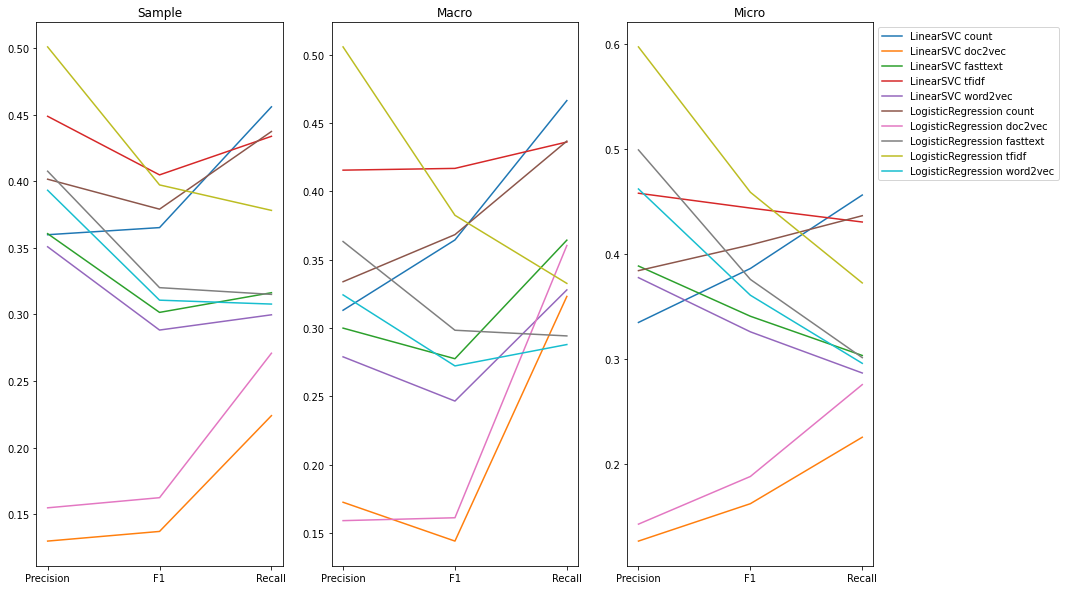

In [6]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [7]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [8]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [9]:
from sklearn.metrics import classification_report
classwise_results = []
for path in top_3:
    clf = load(path)
    test = clf.transform(X_test)
    prediction = clf.predict(test)
    label_accuracies = per_label_accuracy(y_test, prediction)
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    name = re.findall(r'\(([\w,\d]*)\)', str(path))[0]
    transformer = re.findall(r'=([\w,\d]*)', str(path))[1]
    classwise_results.append((name + ' ' + transformer, classwise_report))

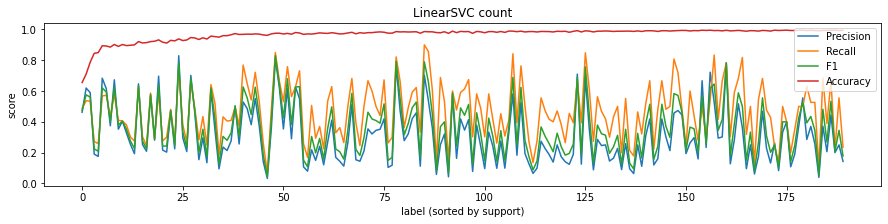

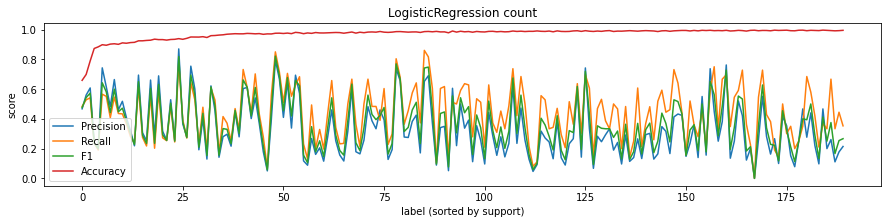

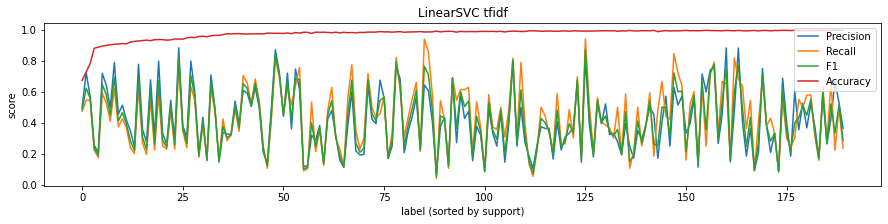

In [10]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()